In [1]:
import sys
sys.path.append("/home/wanxinli/deep_patient")

from common import *
from deep_patient.sda import SDA
import numpy as np
import ot
import pandas as pd
from scipy import sparse
from sklearn import linear_model

base_dir = "/home/wanxinli/deep_patient"
data_dir = "outputs/synthetic/simple"


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
"""
Generate synthetic dataset for males in the following way:
(integer) medical code range: [0, 20]
explanatory data dimension: [100, 10] for males 
label: expire, = 1 if a row has both 1 and 2
"""

def gen_label(seqs, code_1, code_2):
    expires = []
    for seq in seqs:
        if code_1 in seq or code_2 in seq: # our mechnism for determining expired label
            expires.append(1)
        else:
            expires.append(0)
    return np.array(expires)

def gen_male_seqs_labels():
    """
    Generate male seqs and labels (expires)
    """
    male_seqs = np.random.randint(low=0, high=20, size=[100, 10])
    male_expires = gen_label(male_seqs, 1, 2)
    return male_seqs, male_expires


In [3]:
"""
Generate synthetic dataset for females in the following way:
swap 1 with 3, 2 with 4 in the male dataset
"""

def gen_female_seqs_labels(male_seqs): 
    """
    Generate female seqs and labels (expires)
    """
    female_seqs = []
    for male_seq in male_seqs:
        female_seq = []
        for code in male_seq:
            if code == 1:
                female_seq.append(3)
            elif code == 3:
                female_seq.append(1)
            elif code == 2:
                female_seq.append(4)
            elif code == 4:
                female_seq.append(2)
            else:
                female_seq.append(code)
        female_seqs.append(female_seq)

    female_seqs = np.array(female_seqs)
    female_expires = gen_label(female_seqs, 3, 4)
    return female_seqs, female_expires



In [4]:
""" 
Simulation mechnism 
"""

def simulate():
    """ 
    Wrapper function for the simulation mechinism
    """

    male_seqs, male_labels = gen_male_seqs_labels()
    female_seqs, female_labels = gen_female_seqs_labels(male_seqs)
    return male_seqs, male_labels, female_seqs, female_labels

In [5]:
"""
Train deep patient model and generate representations for males and females
"""

def custom_train_reps(male_seqs, female_seqs):
    """ 
    Customized training algorithm for generating male representations and female representations
    
    :returns: male representations, female representations
    """

    # customized parameters
    nhidden = 5
    nlayer = 1

    # for males
    # initiate the model
    male_sda = SDA(male_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 10,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    male_sda.train(male_seqs)

    # apply the mode
    male_reps = male_sda.apply(male_seqs)

    # for females
    # initiate the model
    female_sda = SDA(female_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 10,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    female_sda.train(female_seqs)

    # apply the mode
    female_reps = female_sda.apply(female_seqs)
    return male_reps, female_reps


In [6]:
""" 
Run the entire procedure multiple times
"""

male_accuracies, male_precisions, male_recalls, \
    female_accuracies, female_precisions, female_recalls, \
    trans_female_accuracies, trans_female_precisions, trans_female_recalls = \
    run_proc_multi(simulate, custom_train_reps)

initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 10
(*) no. of hidden units: 5
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 10

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 8.139
(*) epoch 2, cost 6.637
(*) epoch 3, cost 6.407
(*) training time: 0.01 sec.

training time: 1.33 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 10
(*) no. of hidden units: 5
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 10

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 6.935
(*) epoch 2, cost 6.497
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units:

In [7]:
""" 
Save precisions and recalls to scores.csv
"""

save_scores(male_accuracies, male_precisions, male_recalls, \
    female_accuracies, female_precisions, female_recalls, \
    trans_female_accuracies, trans_female_precisions, trans_female_recalls,\
    os.path.join(base_dir, data_dir))

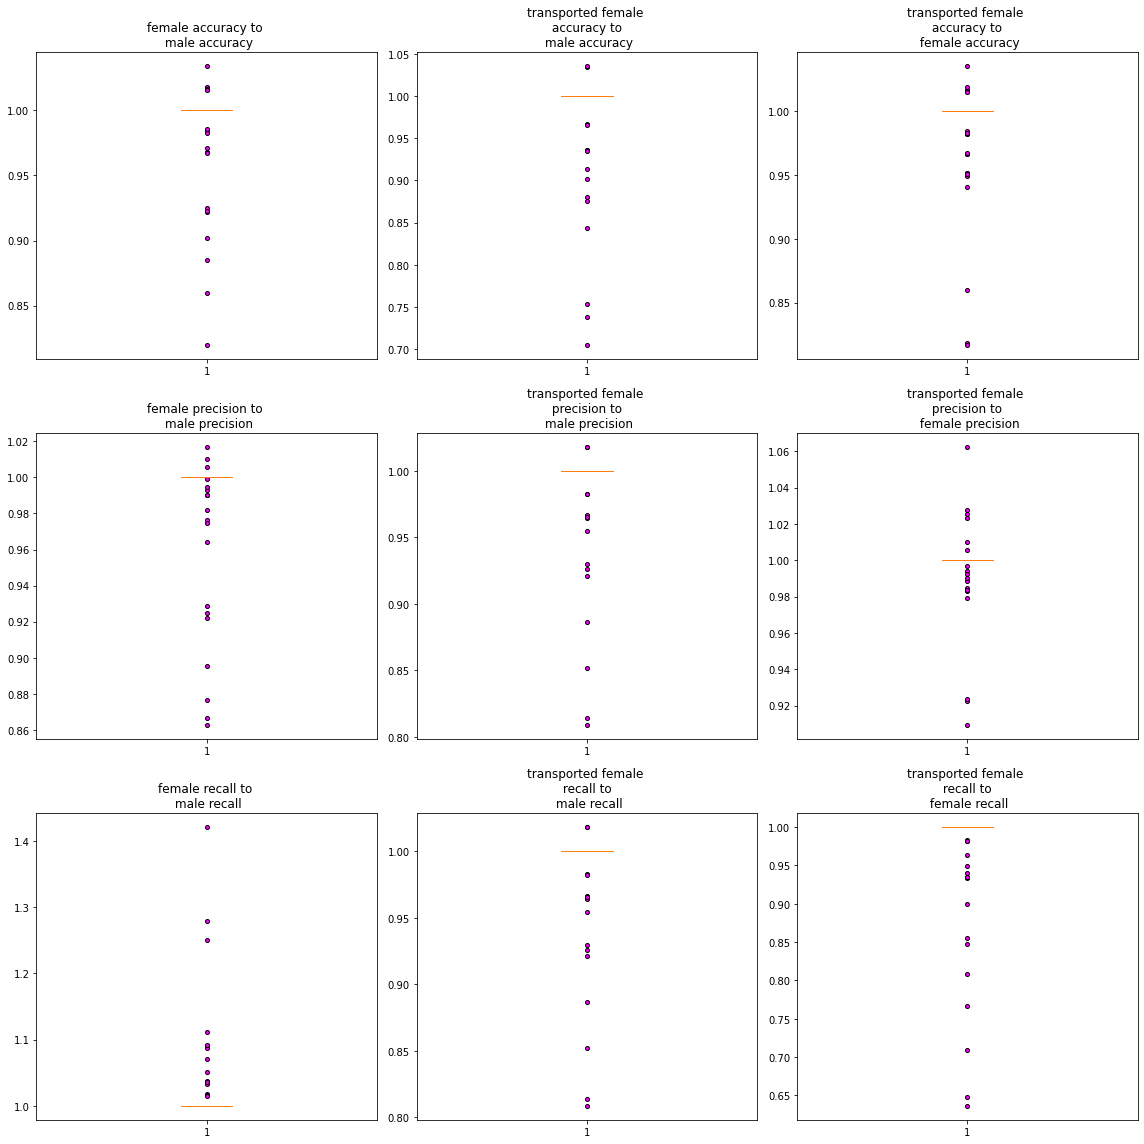

In [8]:
""" 
Box plot of the precision and recalls 
"""

box_plot(os.path.join(base_dir, data_dir, "scores.csv"))